In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import entropy as calculate_entropy

from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [953]:
# total number of samples needed
datasize = 100
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [954]:
labels, clean_docs, all_docs = [], [], []
max_document_length = 256

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):    
    status, doc, word_count = clean_doc(doc)
    
    if not status:
        continue
        
    all_docs.append(doc)
    
    if (max_document_length is not None and len(doc) > max_document_length):
        continue
        
    if len(clean_docs) == datasize*len(label_classes):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(doc)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watching around in a secluded spot etc have my key ready to open the door so i m


In [955]:
sizes

[100, 100, 100, 100]

In [956]:
assert min(sizes) == max(sizes) and min(sizes) == datasize, "Size Mismatch!"
print(f"there are {len(all_docs)} all docs and {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 2069 all docs and 400 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:100, max:100


### count words

In [980]:
mode = "tfidf"
# mode = "binary"
# mode = "normalize"
# mode = "binary-normalize"

# initialize the count vectorizer
vectorizer = TfidfVectorizer() if mode == "tfidf" else CountVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)

vectorizer.fit(train_docs)
vocabulary = vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 2318


### Prepare Datatset

In [981]:
# create doc count vectors
all_doc_vectors = vectorizer.transform(all_docs).toarray()
train_doc_vectors = vectorizer.transform(train_docs).toarray()
test_doc_vectors = vectorizer.transform(test_docs).toarray()

if mode == "binary-normalize" or mode == "binary":
    all_doc_vectors = (all_doc_vectors > 0).astype(float)
    train_doc_vectors = (train_doc_vectors > 0).astype(float)
    test_doc_vectors = (test_doc_vectors > 0).astype(float)
    
if mode == "normalize" or mode == "binary-normalize":
    all_doc_vectors = normalize(all_doc_vectors, norm="l1", axis=1)
    train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
    test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

268 train_docs, 132 test docs


In [982]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=vocabulary)
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (268, 2319)


In [983]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 400 docs and 4 classes


In [984]:
document_word_frequency.head()

,000,013846,020359,077,0a,0x100,10,100,10k,12,...,year,yellow,yes,yet,yo,you,your,yuan,zip,__labels__
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.073684,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1


### Word-Word Ratio

In [1071]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = pd.DataFrame(all_doc_vectors, columns=vocabulary)

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
# all_docs_trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
all_docs_trust_factor = ((word_doc_freqency > 0).sum(0) / len(all_doc_vectors))

for word in tqdm(vocabulary):
    word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
    word_word_co[word] = ((word_word_frequency * all_docs_trust_factor) / word_doc_total_frequency).fillna(0)

print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (2318, 2318)


In [1072]:
word_word_co.head()

,000,013846,020359,077,0a,0x100,10,100,10k,12,...,yeah,year,yellow,yes,yet,yo,you,your,yuan,zip
000,0.030933,0.000000,0.000000,0.000000,0.000000,0.000542,0.010458,0.00705,0.000083,0.00615,...,0.0,0.007359,0.00039,0.002581,0.004882,0.0,0.017055,0.007959,0.0,0.000098
013846,0.000000,0.000483,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000483,0.000000,0.0,0.000000
020359,0.000000,0.000000,0.000483,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
077,0.000000,0.000000,0.000000,0.000483,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
0a,0.000000,0.000000,0.000000,0.000000,0.000483,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [1079]:
skew_factor = word_word_co.std(1)
skew_factor /= skew_factor.max()
skew_factor = 1 - skew_factor

wwc = (word_word_co * skew_factor)
# wwc = (wwc.T / wwc.sum(1)).T

In [1080]:
skew_factor["the"], skew_factor["on"]

(0.0, 0.45697973948421333)

In [1081]:
word = "software"
word_word_co.loc[word].sort_values(ascending=False).head()

software    0.047849
to          0.042298
the         0.040703
and         0.039950
of          0.036963
Name: software, dtype: float64

In [1082]:
wwc.loc[word].sort_values(ascending=False).head()

software    0.045140
system      0.015511
or          0.015327
on          0.014492
will        0.014349
Name: software, dtype: float64

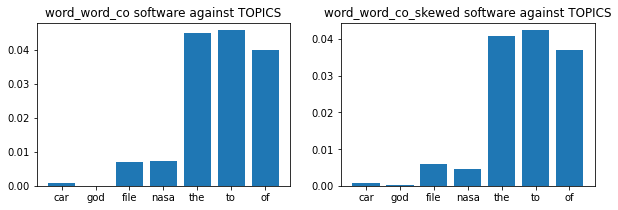

In [1084]:
words = ["car", "god", "file", "nasa", "the", "to", "of"]

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(f"word_word_co {word} against TOPICS")
ax1.bar(words, word_word_co[word][words])

ax2.set_title(f"word_word_co_skewed {word} against TOPICS")
ax2.bar(words, word_word_co.loc[word][words])

plt.show()

In [1015]:
wwc.loc[word][words]

car     0.000218
god     0.000106
file    0.001843
nasa    0.001447
the     0.000000
to      0.001611
of      0.002066
Name: software, dtype: float64

In [1016]:
word_word_co.loc[word][words]

car     0.000760
god     0.000340
file    0.005827
nasa    0.004599
the     0.040703
to      0.042298
of      0.036963
Name: software, dtype: float64

### Topic and word corelation

In [1089]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)
trust_factor = sigmoid((word_doc_freqency > 0).sum(0))

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

# entropy = topic_word_distr.std(1)
# skew_factor = gaussian((np.nan_to_num(calculate_entropy(topic_word_distr.T, base=2))))
# topic_word_distr = (topic_word_distr.T * skew_factor).T

print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (2318, 4)


In [1094]:
skew_factor = gaussian((np.nan_to_num(calculate_entropy(topic_word_distr.T, base=2))))

In [1095]:
np.array(vocabulary)[skew_factor.argsort()][:100]

array(['from', 'that', 'of', 'while', 'and', 'in', 'all', 'this', 'the',
       'if', 'might', 'is', 'go', 'how', 'to', 'still', 'these', 'have',
       'than', 'you', 'think', 'doe', 'other', 'like', 'out', 'though',
       'them', 'because', 'would', 'do', 'on', 'world', 'don', 'but',
       'are', 'thought', 'wasn', 'interested', 'no', 'it', 'be', 'or',
       'then', 'may', 'wa', 'at', 'more', 'why', 'did', 'time', 'by',
       'made', 'well', 'we', 'want', 'after', 'used', 'so', 'not',
       'maybe', 'when', 'something', 'same', 'ha', 'what', 'with',
       'where', 'book', 'make', 'great', 'our', 'they', 'talking',
       'there', 'can', 'just', 'someone', 'article', 'name', 'here',
       'get', 'year', 'which', 'know', 'will', 'good', 'find', 're',
       'who', 'ago', 'being', 'am', 'some', 'lot', 'about', 'rather',
       'hello', 'sorry', 'their', 'also'], dtype='<U16')

In [1018]:
topic_word_distr.head()

,autos,religion,graphics,space
000,0.354579,0.0,0.117872,0.000000
013846,0.000000,0.0,0.730452,0.000000
020359,0.000000,0.0,0.000000,0.730386
077,0.000000,0.0,0.730404,0.000000
0a,0.000000,0.0,0.730386,0.000000


In [1019]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [1020]:
label_class = 'graphics'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

vga        0.975044
library    0.970289
map        0.963537
hi         0.959768
color      0.956999
             ...   
that       0.001313
is         0.001147
and        0.000979
of         0.000800
to         0.000459
Name: graphics, Length: 825, dtype: float64

In [1021]:
word="to"
topic_word_distr.loc[word].sort_values(ascending=False)

religion    0.000751
space       0.000598
autos       0.000482
graphics    0.000459
Name: to, dtype: float64

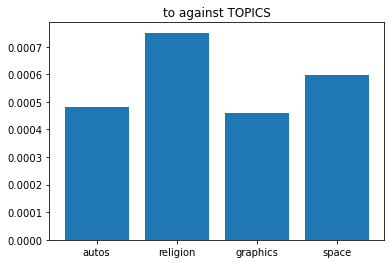

In [1022]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [1023]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 99.25%, 2 misclassified



### Evaluating Topic Model with test set

In [1024]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 51.52%, avg-accuarcy = 75.38%, 64 misclassified



### Investigating Misclassification

In [1001]:
training = False
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
    break

              autos  religion  graphics     space
objective  0.000000  0.168298  0.000000  0.070854
theory     0.000000  0.123102  0.000000  0.111267
idea       0.000000  0.000000  0.159431  0.067150
different  0.000000  0.074581  0.000000  0.142098
sensible   0.000000  0.000000  0.000000  0.212105
accept     0.000000  0.000000  0.000000  0.207907
reality    0.000000  0.207738  0.000000  0.000000
mark       0.000000  0.000000  0.000000  0.206916
sorry      0.032657  0.106577  0.036997  0.028271
people     0.091471  0.040358  0.011194  0.030344
than       0.049673  0.033202  0.030875  0.054409
more       0.034206  0.032841  0.021343  0.055875
your       0.073619  0.039108  0.022187  0.007581
an         0.045368  0.021946  0.034077  0.003582
about      0.048206  0.029368  0.015888  0.010704
can        0.016545  0.009059  0.036649  0.025366
but        0.010960  0.025830  0.018874  0.024425
is         0.012552  0.017515  0.012263  0.016734
that       0.009343  0.009678  0.008212  0.008230


### Using Multinomial Naive Bayes

In [1002]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 99.63%, test_accuarcy = 59.85%, avg-accuarcy = 79.74%
